# Long-Short Strategy, Part 3: Evaluating our Boosting Model Signals

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. `evaluate_trading_signals` (this noteboook): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

Cross-validation of numerous configurations has produced a large number of results. Now, we need to evaluate the predictive performance to identify the model that generates the most reliable and profitable signals for our prospective trading strategy.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
import warnings
from pathlib import Path
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from scipy.stats import spearmanr, pearsonr

from alphalens import plotting
from alphalens import performance as perf
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return, std_conversion
from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [4]:
sns.set_style('whitegrid')

In [5]:
YEAR = 252
idx = pd.IndexSlice

In [6]:
scope_params = ['lookahead', 'train_length', 'test_length']
daily_ic_metrics = ['daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']
lgb_train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']
catboost_train_params = ['max_depth', 'min_child_samples']

In [ ]:
results_path = Path('results', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Collect Data

We produced a larger number of LightGBM models because it runs an order of magnitude faster than CatBoost and will demonstrate some evaluation strategies accordingly.

### LightGBM

#### Summary Metrics by Fold

First, we collect the summary metrics computed for each fold and hyperparameter combination:

In [10]:
lgb_metrics = []
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    for i, key in enumerate(
        [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead': t,
            'train_length': train_length,
            'test_length': test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            lgb_metrics = pd.Series(s).to_frame(i)
        else:
            lgb_metrics[i] = pd.Series(s)

id_vars = scope_params + lgb_train_params + daily_ic_metrics
lgb_metrics = pd.melt(lgb_metrics.T.drop('t', axis=1), 
                  id_vars=id_vars, 
                  value_name='ic', 
                  var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [11]:
lgb_metrics.to_hdf('data/model_tuning.h5', 'lgb/metrics')
lgb_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2457 entries, 0 to 2456
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          2457 non-null   int64  
 1   train_length       2457 non-null   int64  
 2   test_length        2457 non-null   int64  
 3   learning_rate      2457 non-null   float64
 4   num_leaves         2457 non-null   float64
 5   feature_fraction   2457 non-null   float64
 6   min_data_in_leaf   2457 non-null   float64
 7   daily_ic_mean      2457 non-null   float64
 8   daily_ic_mean_n    2457 non-null   float64
 9   daily_ic_median    2457 non-null   float64
 10  daily_ic_median_n  2457 non-null   float64
 11  boost_rounds       2457 non-null   int64  
 12  ic                 2457 non-null   float64
dtypes: float64(9), int64(4)
memory usage: 268.7 KB


In [12]:
lgb_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          756           63             351
           1134          63             486
5          756           63             324
           1134          63             486
21         756           63             324
           1134          63             486
dtype: int64

#### Information Coefficient by Day

Next, we retrieve the IC per day computed during cross-validation:

In [13]:
int_cols = ['lookahead', 'train_length', 'test_length', 'boost_rounds']

In [14]:
lgb_ic = []
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key]
                  .drop(['boosting', 'objective', 'verbose'], axis=1)
                 .assign(lookahead=t, 
                         train_length=train_length, 
                         test_length=test_length))
            lgb_ic.append(df)
    lgb_ic = pd.concat(lgb_ic).reset_index()

In [15]:
id_vars = ['date'] + scope_params + lgb_train_params
lgb_ic = pd.melt(lgb_ic, 
                 id_vars=id_vars, 
                 value_name='ic', 
                 var_name='boost_rounds').dropna()
lgb_ic.loc[:, int_cols] = lgb_ic.loc[:, int_cols].astype(int)

In [16]:
lgb_ic.to_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_ic.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1564369 entries, 0 to 1788695
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   date              1564369 non-null  datetime64[ns]
 1   lookahead         1564369 non-null  int64         
 2   train_length      1564369 non-null  int64         
 3   test_length       1564369 non-null  int64         
 4   learning_rate     1564369 non-null  float64       
 5   num_leaves        1564369 non-null  int64         
 6   feature_fraction  1564369 non-null  float64       
 7   min_data_in_leaf  1564369 non-null  int64         
 8   boost_rounds      1564369 non-null  int64         
 9   ic                1564369 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 131.3 MB


In [17]:
lgb_daily_ic = lgb_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
lgb_daily_ic.to_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3105 entries, 0 to 3104
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         3105 non-null   int64  
 1   train_length      3105 non-null   int64  
 2   test_length       3105 non-null   int64  
 3   learning_rate     3105 non-null   float64
 4   num_leaves        3105 non-null   int64  
 5   feature_fraction  3105 non-null   float64
 6   min_data_in_leaf  3105 non-null   int64  
 7   boost_rounds      3105 non-null   int64  
 8   ic                3105 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 218.4 KB


In [18]:
lgb_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')

### CatBoost

We proceed similarly for CatBoost:

#### Summary Metrics

In [19]:
catboost_metrics = []
with pd.HDFStore('data/tuning_catboost.h5') as store:
    for i, key in enumerate(
            [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead'   : t,
            'train_length': train_length,
            'test_length' : test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            catboost_metrics = pd.Series(s).to_frame(i)
        else:
            catboost_metrics[i] = pd.Series(s)

id_vars = scope_params + catboost_train_params + daily_ic_metrics
catboost_metrics = pd.melt(catboost_metrics.T.drop('t', axis=1),
                           id_vars=id_vars,
                           value_name='ic',
                           var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [20]:
catboost_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 1175
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          1176 non-null   int64  
 1   train_length       1176 non-null   int64  
 2   test_length        1176 non-null   int64  
 3   max_depth          1176 non-null   float64
 4   min_child_samples  1176 non-null   float64
 5   daily_ic_mean      1176 non-null   float64
 6   daily_ic_mean_n    1176 non-null   float64
 7   daily_ic_median    1176 non-null   float64
 8   daily_ic_median_n  1176 non-null   float64
 9   boost_rounds       1176 non-null   int64  
 10  ic                 1176 non-null   float64
dtypes: float64(7), int64(4)
memory usage: 110.2 KB


In [21]:
catboost_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          252           21             168
           756           63             168
           1134          63             168
5          252           21             168
           756           63             168
21         252           63             168
           756           63             168
dtype: int64

#### Daily Information Coefficient

In [22]:
catboost_ic = []
with pd.HDFStore('data/tuning_catboost.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key].drop('task_type', axis=1)
                 .assign(lookahead=t,
                         train_length=train_length,
                         test_length=test_length))
            catboost_ic.append(df)
    catboost_ic = pd.concat(catboost_ic).reset_index()

In [23]:
id_vars = ['date'] + scope_params + catboost_train_params
catboost_ic = pd.melt(catboost_ic, 
                      id_vars=id_vars, 
                      value_name='ic', 
                      var_name='boost_rounds').dropna()
catboost_ic.loc[:, int_cols] = catboost_ic.loc[:, int_cols].astype(int)

In [24]:
catboost_ic.to_hdf('data/model_tuning.h5', 'catboost/ic')
catboost_ic.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592704 entries, 0 to 592703
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               592704 non-null  datetime64[ns]
 1   lookahead          592704 non-null  int64         
 2   train_length       592704 non-null  int64         
 3   test_length        592704 non-null  int64         
 4   max_depth          592704 non-null  int64         
 5   min_child_samples  592704 non-null  int64         
 6   boost_rounds       592704 non-null  int64         
 7   ic                 592704 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 40.7 MB


In [25]:
catboost_daily_ic = catboost_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
catboost_daily_ic.to_hdf('data/model_tuning.h5', 'catboost/daily_ic')
catboost_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          1176 non-null   int64  
 1   train_length       1176 non-null   int64  
 2   test_length        1176 non-null   int64  
 3   max_depth          1176 non-null   int64  
 4   min_child_samples  1176 non-null   int64  
 5   boost_rounds       1176 non-null   int64  
 6   ic                 1176 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 64.4 KB


In [26]:
catboost_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/ic')
catboost_daily_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/daily_ic')

## Validation Performance: Daily vs Overall Information Coefficient

The following image shows that that LightGBM (in orange) performs (slightly) better than CatBoost, especially for longer horizons. This is not an entirely fair comparison because we ran more configurations for LightGBM, which also, unsurprisingly, shows a wider dispersion of outcomes:


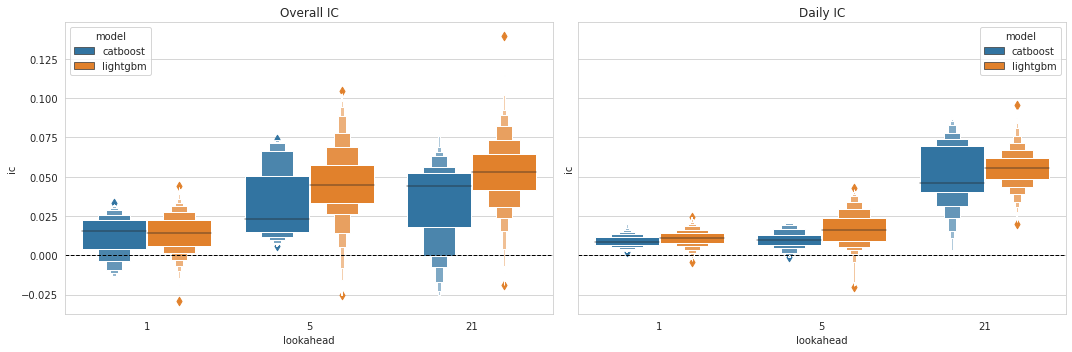

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=catboost_metrics.assign(model='catboost')
              .append(lgb_metrics.assign(model='lightgbm')), ax=axes[0])
axes[0].axhline(0, ls='--', lw=1, c='k')
axes[0].set_title('Overall IC')
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=catboost_daily_ic.assign(model='catboost')
              .append(lgb_daily_ic.assign(model='lightgbm')), ax=axes[1])
axes[1].axhline(0, ls='--', lw=1, c='k')
axes[1].set_title('Daily IC')
fig.tight_layout()

## HyperParameter Impact: Linear Regression

Next, we'd like to understand if there's a systematic, statistical relationship between the hyperparameters and the outcomes across daily predictions. To this end, we will run a linear regression using the various LightGBM hyperparameter settings as dummy variables and the daily validation IC as the outcome.

The below chart shows the coefficient estimates and their confidence intervals for 1- and 21-day forecast horizons. 
- For the shorter horizon, a longer lookback period, a higher learning rate, and deeper trees (more leaf nodes) have a positive impact. 
- For the longer horizon, the picture is a little less clear: shorter trees do better, but the lookback period is not significant. A higher feature sampling rate also helps. In both cases, a larger ensemble does better. 

Note that these results apply to this specific example only.

In [28]:
lin_reg = {}
for t in [1, 21]:
    df_ = lgb_ic[lgb_ic.lookahead==t]
    y, X = df_.ic, df_.drop(['ic'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err', 't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(f'results/linreg_result_{t:02}.csv', index=False)

In [29]:
def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith('date')&(coefs.variable!='const')]

    coefs.plot(x='variable', y='coef', kind='bar', 
                 ax=ax, color='none', capsize=3,
                 yerr='error', legend=False)
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

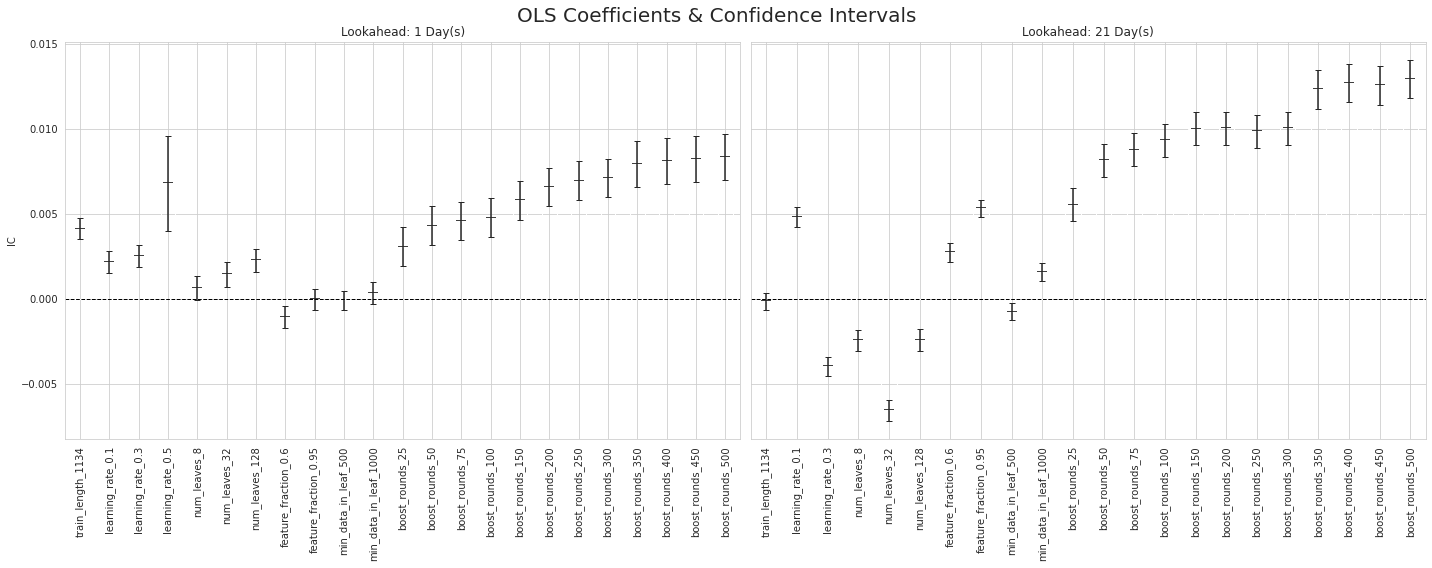

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    visualize_lr_result(lin_reg[t], axes[i])
    axes[i].set_title(f'Lookahead: {t} Day(s)')
fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.92)
fig.savefig('figures/ols_coefs', dpi=300);

## Cross-validation Result: Best Hyperparameters

### LightGBM

The top-performing LightGBM models use the following parameters for the three different prediction horizons.

In [31]:
group_cols = scope_params + lgb_train_params + ['boost_rounds']
lgb_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,boost_rounds,ic
595,1,1134,63,0.01,128,0.95,250,400,0.024674
596,1,1134,63,0.01,128,0.95,250,450,0.024292
610,1,1134,63,0.01,128,0.95,500,500,0.024198
1569,5,1134,63,0.10,4,0.30,500,400,0.042814
1568,5,1134,63,0.10,4,0.30,500,350,0.041771
1570,5,1134,63,0.10,4,0.30,500,450,0.041151
2260,21,756,63,0.10,128,0.95,1000,25,0.095405
2261,21,756,63,0.10,128,0.95,1000,50,0.091278
2262,21,756,63,0.10,128,0.95,1000,75,0.089669


In [32]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')).to_csv('results/best_lgb_model.csv', index=False)

In [33]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'daily_ic_mean'))

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
267,1,1134,63,0.01,128.0,0.95,250.0,0.024674,400.0,0.023807,500.0,10,-0.002447
540,1,1134,63,0.01,128.0,0.95,250.0,0.024674,400.0,0.023807,500.0,25,-0.000077
813,1,1134,63,0.01,128.0,0.95,250.0,0.024674,400.0,0.023807,500.0,50,-0.000030
63,5,1134,63,0.10,4.0,0.30,500.0,0.042814,400.0,0.038330,500.0,10,0.055980
336,5,1134,63,0.10,4.0,0.30,500.0,0.042814,400.0,0.038330,500.0,25,0.055506
609,5,1134,63,0.10,4.0,0.30,500.0,0.042814,400.0,0.038330,500.0,50,0.045449
120,21,756,63,0.10,128.0,0.95,1000.0,0.095405,25.0,0.099453,25.0,10,0.082795
393,21,756,63,0.10,128.0,0.95,1000.0,0.095405,25.0,0.099453,25.0,25,0.076064
666,21,756,63,0.10,128.0,0.95,1000.0,0.095405,25.0,0.099453,25.0,50,0.072365


### CatBoost

In [34]:
group_cols = scope_params + catboost_train_params + ['boost_rounds']
catboost_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,lookahead,train_length,test_length,max_depth,min_child_samples,boost_rounds,ic
341,1,1134,63,3,20,200,0.019974
355,1,1134,63,3,250,200,0.019974
369,1,1134,63,3,500,200,0.019973
679,5,756,63,3,20,400,0.021375
693,5,756,63,3,250,400,0.021375
707,5,756,63,3,500,400,0.021375
1051,21,756,63,5,20,25,0.088109
1065,21,756,63,5,250,25,0.088109
1079,21,756,63,5,500,25,0.088109


In [35]:
catboost_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,lookahead,train_length,test_length,max_depth,min_child_samples,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
920,1,1134,63,5.0,500.0,0.015616,10.0,0.016628,10.0,700,0.032989
836,1,1134,63,5.0,500.0,0.015616,10.0,0.016628,10.0,600,0.032336
1172,1,1134,63,5.0,500.0,0.015616,10.0,0.016628,10.0,1000,0.032125
935,5,756,63,3.0,500.0,0.021375,400.0,0.021886,600.0,800,0.073752
1102,5,756,63,3.0,250.0,0.021375,400.0,0.021290,300.0,1000,0.073468
513,5,756,63,3.0,20.0,0.021375,400.0,0.021886,600.0,300,0.073285
33,21,756,63,3.0,20.0,0.077041,500.0,0.094301,300.0,10,0.085074
34,21,756,63,3.0,250.0,0.077041,500.0,0.094301,300.0,10,0.085074
35,21,756,63,3.0,500.0,0.076753,500.0,0.094931,300.0,10,0.085074


In [36]:
catboost_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'daily_ic_mean'))

,lookahead,train_length,test_length,max_depth,min_child_samples,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
81,1,1134,63,3.0,20.0,0.019974,200.0,0.019573,300.0,10,0.011191
82,1,1134,63,3.0,250.0,0.019974,200.0,0.019452,300.0,10,0.011191
165,1,1134,63,3.0,20.0,0.019974,200.0,0.019573,300.0,25,0.013491
9,5,756,63,3.0,20.0,0.021375,400.0,0.021886,600.0,10,0.012467
10,5,756,63,3.0,250.0,0.021375,400.0,0.021290,300.0,10,0.012467
11,5,756,63,3.0,500.0,0.021375,400.0,0.021886,600.0,10,0.012467
30,21,756,63,5.0,20.0,0.088109,25.0,0.098979,50.0,10,-0.004620
31,21,756,63,5.0,250.0,0.088109,25.0,0.098979,50.0,10,-0.004620
32,21,756,63,5.0,500.0,0.088109,25.0,0.098979,50.0,10,-0.004620


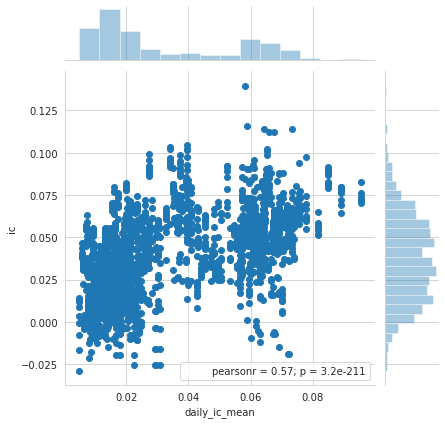

In [37]:
sns.jointplot(x=lgb_metrics.daily_ic_mean,y=lgb_metrics.ic).annotate(pearsonr);

### Visualization

#### LightGBM

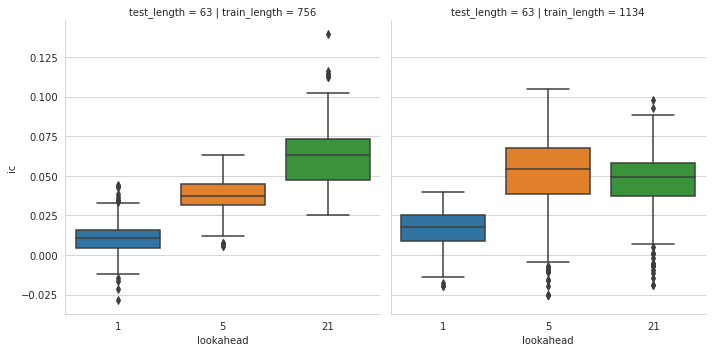

In [38]:
g = sns.catplot(x='lookahead', y='ic',
                col='train_length', row='test_length',
                data=lgb_metrics,
                kind='box')

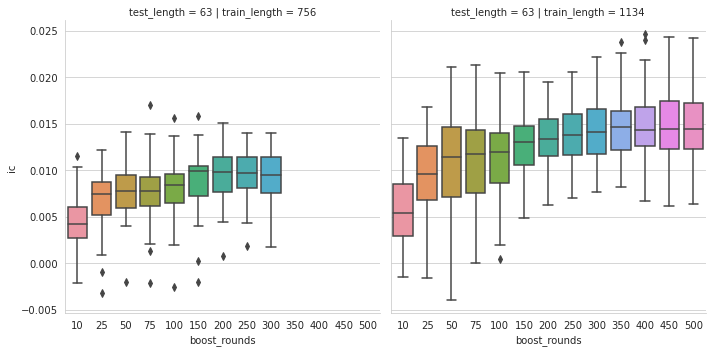

In [39]:
t=1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=lgb_daily_ic[lgb_daily_ic.lookahead == t],
            kind='box')

#### CatBoost

Some figures are empty because we did not run those parameter combinations.

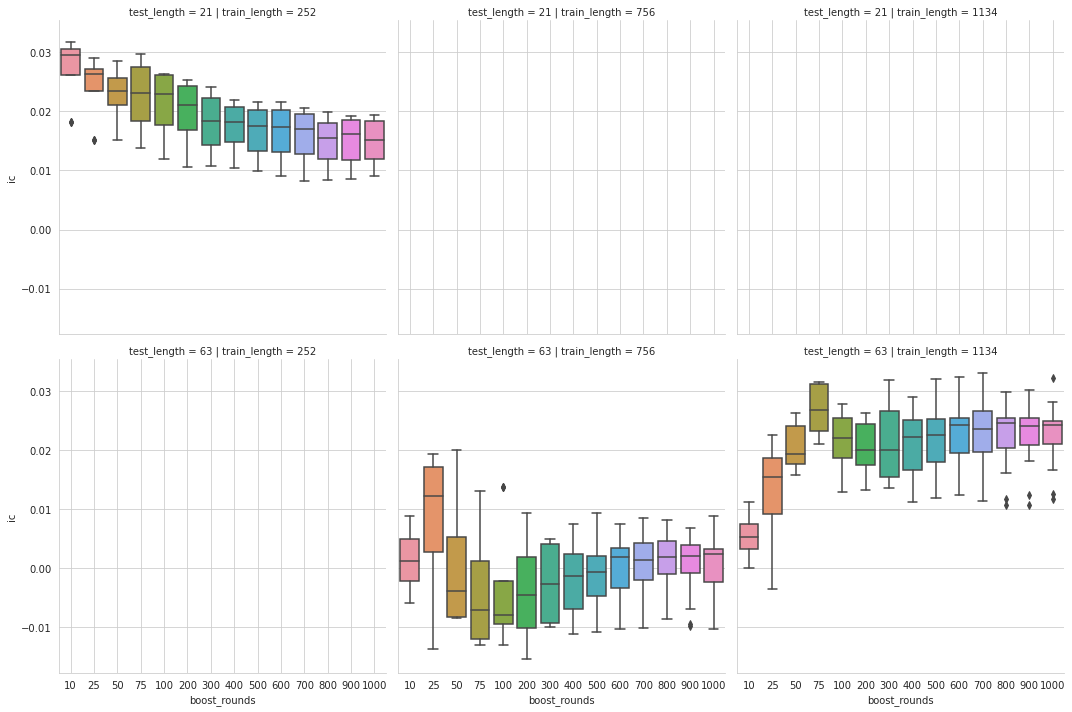

In [42]:
t = 1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=catboost_metrics[catboost_metrics.lookahead == t],
            kind='box')

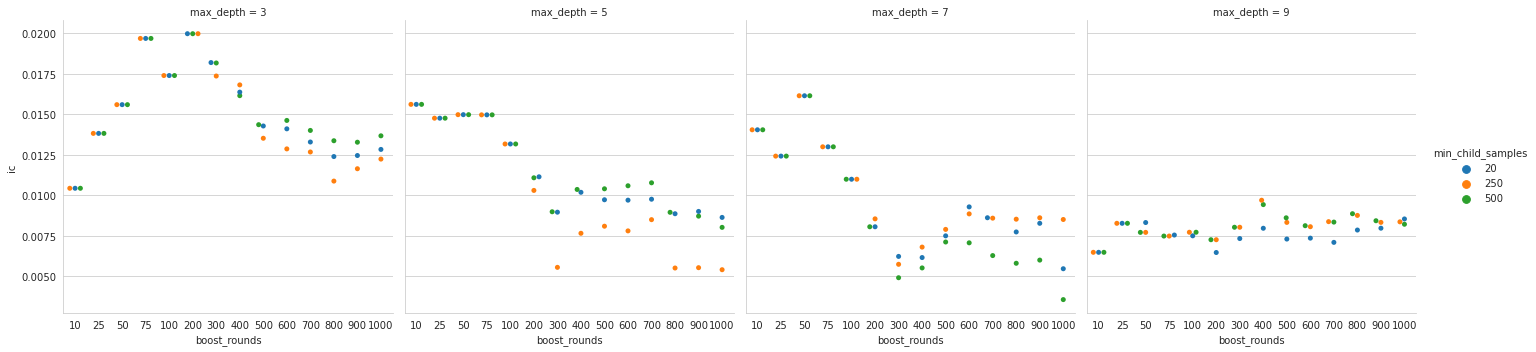

In [49]:
t = 1
train_length = 1134
test_length = 63
g = sns.catplot(
    x='boost_rounds',
    y='ic',
    col='max_depth',
    hue='min_child_samples',
    data=catboost_daily_ic[(catboost_daily_ic.lookahead == t) &
                      (catboost_daily_ic.train_length == train_length) &
                      (catboost_daily_ic.test_length == test_length)],
    kind='swarm')

## AlphaLens Analysis - Validation Performance

### LightGBM

#### Select Parameters

In [50]:
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3105 entries, 0 to 3104
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         3105 non-null   int64  
 1   train_length      3105 non-null   int64  
 2   test_length       3105 non-null   int64  
 3   learning_rate     3105 non-null   float64
 4   num_leaves        3105 non-null   int64  
 5   feature_fraction  3105 non-null   float64
 6   min_data_in_leaf  3105 non-null   int64  
 7   boost_rounds      3105 non-null   int64  
 8   ic                3105 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 242.6 KB


In [51]:
def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [52]:
def get_lgb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/{p.learning_rate}/'
    return key + f'{int(p.num_leaves)}/{p.feature_fraction}/{int(p.min_data_in_leaf)}'

In [74]:
best_params = get_lgb_params(lgb_daily_ic, t=1, best=0)
best_params

train_length        1134.00
test_length           63.00
learning_rate          0.01
num_leaves           128.00
feature_fraction       0.95
min_data_in_leaf     250.00
boost_rounds         400.00
Name: 595, dtype: float64

In [76]:
best_params.to_hdf('data.h5', 'best_params')

#### Plot rolling IC

In [54]:
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.learning_rate == params.learning_rate) &
                       (ic_data.num_leaves == params.num_leaves) &
                       (ic_data.feature_fraction == params.feature_fraction) &
                       (ic_data.boost_rounds == params.boost_rounds), ['date', 'ic']].set_index('date')

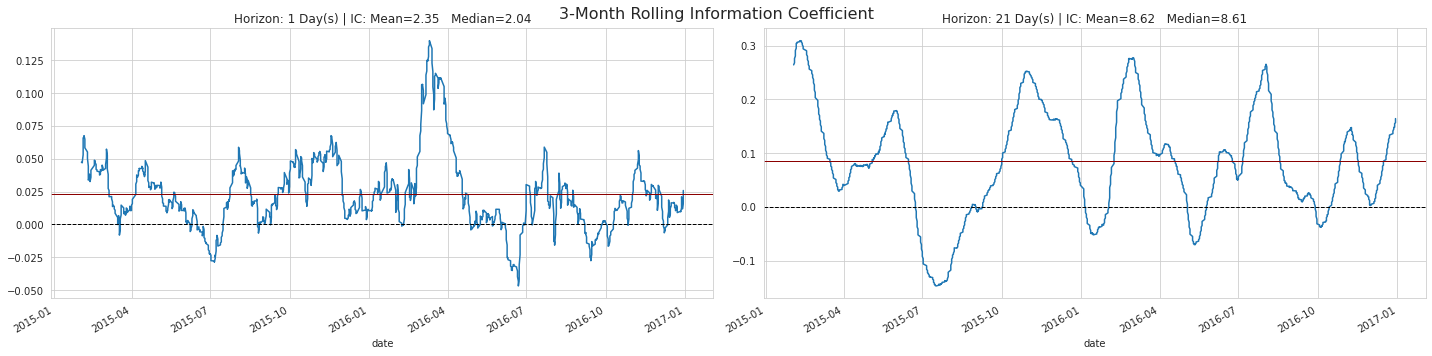

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    params = get_lgb_params(lgb_daily_ic, t=t)
    data = select_ic(params, lgb_ic, lookahead=t).sort_index()
    rolling = data.rolling(63).ic.mean().dropna()
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.savefig('figures/rolling_ic_lgb', dpi=300);

#### Get Predictions for Validation Period

We retrieve the predictions for the 10 validation runs:

In [56]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_lgb_params(lgb_daily_ic, t=lookahead, best=best)
    key = get_lgb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_lgb.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_lgb.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [57]:
best_predictions.to_hdf('data/predictions.h5', f'lgb/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 501310 entries, ('A', Timestamp('2015-01-02 00:00:00')) to ('ZION', Timestamp('2016-12-30 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       501310 non-null  float64
 1   1       501310 non-null  float64
 2   2       501310 non-null  float64
 3   3       501310 non-null  float64
 4   4       501310 non-null  float64
 5   5       501310 non-null  float64
 6   6       501310 non-null  float64
 7   7       501310 non-null  float64
 8   8       501310 non-null  float64
 9   9       501310 non-null  float64
dtypes: float64(10)
memory usage: 40.2+ MB


#### Get Trade Prices

Using next available prices.

In [58]:
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = '../data/assets.h5'
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2015': '2017'], 'adj_open']
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [59]:
test_tickers = best_predictions.index.get_level_values('symbol').unique()

In [60]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 995 entries, A to ZION
dtypes: float64(995)
memory usage: 5.7 MB


In [63]:
# persist result in case we want to rerun:
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

We average the top five models and provide the corresponding prices to Alphalens, in order to compute the mean period-wise return earned on an equal-weighted portfolio invested in the daily factor quintiles for various holding periods:

In [64]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

#### Create AlphaLens Inputs

In [65]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


#### Compute Alphalens metrics

In [66]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

In [67]:
factor_returns = perf.factor_returns(factor_data)

In [68]:
mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data,
                                                            by_group=False,
                                                            demeaned=True)



mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                          base_period=mean_quant_ret.columns[0])

In [69]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],
)

compstd_quant_daily = std_quant_daily.apply(std_conversion,
                                            base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data,
                                    demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,
)

In [70]:
mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

,1D,5D,10D,21D
Mean Period Wise Spread (bps),12.165432,6.951403,4.946450,4.407920
Ann. alpha,0.175933,0.077596,0.044649,0.037394
beta,0.089060,0.151587,0.191898,0.198344


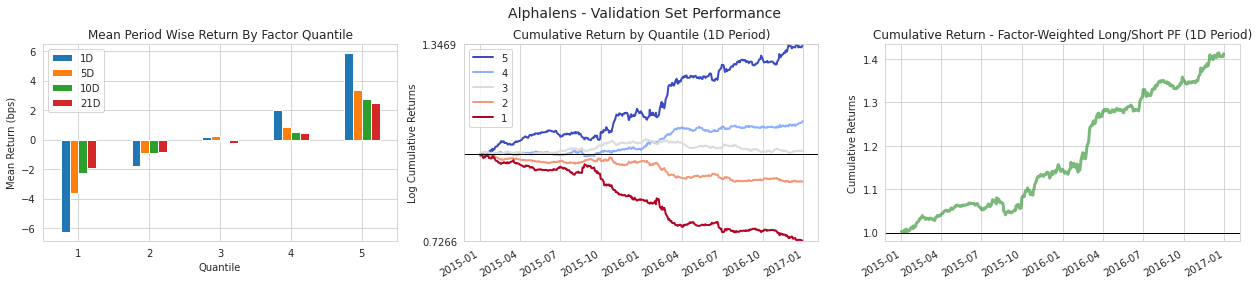

In [71]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))


plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
axes[0].set_xlabel('Quantile')

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'],
                                             freq=pd.tseries.offsets.BDay(),
                                             period='1D',
                                             ax=axes[1])
axes[1].set_title('Cumulative Return by Quantile (1D Period)')

title = "Cumulative Return - Factor-Weighted Long/Short PF (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'],
                                 period='1D',
                                 freq=pd.tseries.offsets.BDay(),
                                 title=title,
                                 ax=axes[2])

fig.suptitle('Alphalens - Validation Set Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig('figures/alphalens_cv', dpi=300)

#### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.043323,0.007629,-0.002025,0.003269,100296,20.006822
2,-0.013078,0.010640,-0.000747,0.002936,100247,19.997048
3,-0.008825,0.012310,-0.000009,0.002950,100223,19.992260
4,-0.008289,0.017452,0.000698,0.003072,100247,19.997048
5,-0.007450,0.052497,0.002109,0.003811,100296,20.006822


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.176,0.078,0.045,0.037
beta,0.089,0.152,0.192,0.198
Mean Period Wise Return Top Quantile (bps),5.884,3.375,2.742,2.496
Mean Period Wise Return Bottom Quantile (bps),-6.282,-3.603,-2.240,-1.946
Mean Period Wise Spread (bps),12.165,6.951,4.946,4.408


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.021,0.022,0.034
IC Std.,0.126,0.136,0.141,0.140
Risk-Adjusted IC,0.162,0.158,0.156,0.246
t-stat(IC),3.638,3.545,3.501,5.515
p-value(IC),0.000,0.000,0.001,0.000
IC Skew,0.065,0.249,0.246,0.087
IC Kurtosis,0.970,1.544,0.567,0.740


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.634,0.654,0.721,0.770
Quantile 2 Mean Turnover,0.751,0.756,0.779,0.790
Quantile 3 Mean Turnover,0.763,0.769,0.783,0.791
Quantile 4 Mean Turnover,0.752,0.756,0.777,0.795
Quantile 5 Mean Turnover,0.622,0.640,0.695,0.738


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.309,0.283,0.164,0.071


<Figure size 432x288 with 0 Axes>

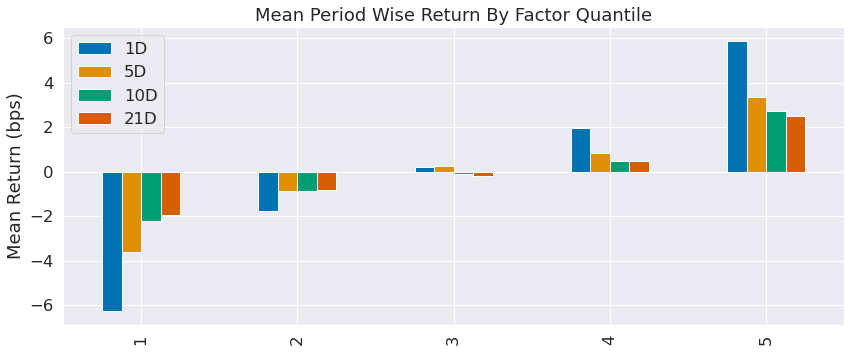

In [72]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.043323,0.007629,-0.002025,0.003269,100296,20.006822
2,-0.013078,0.010640,-0.000747,0.002936,100247,19.997048
3,-0.008825,0.012310,-0.000009,0.002950,100223,19.992260
4,-0.008289,0.017452,0.000698,0.003072,100247,19.997048
5,-0.007450,0.052497,0.002109,0.003811,100296,20.006822


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.176,0.078,0.045,0.037
beta,0.089,0.152,0.192,0.198
Mean Period Wise Return Top Quantile (bps),5.884,3.375,2.742,2.496
Mean Period Wise Return Bottom Quantile (bps),-6.282,-3.603,-2.240,-1.946
Mean Period Wise Spread (bps),12.165,6.951,4.946,4.408


<Figure size 432x288 with 0 Axes>

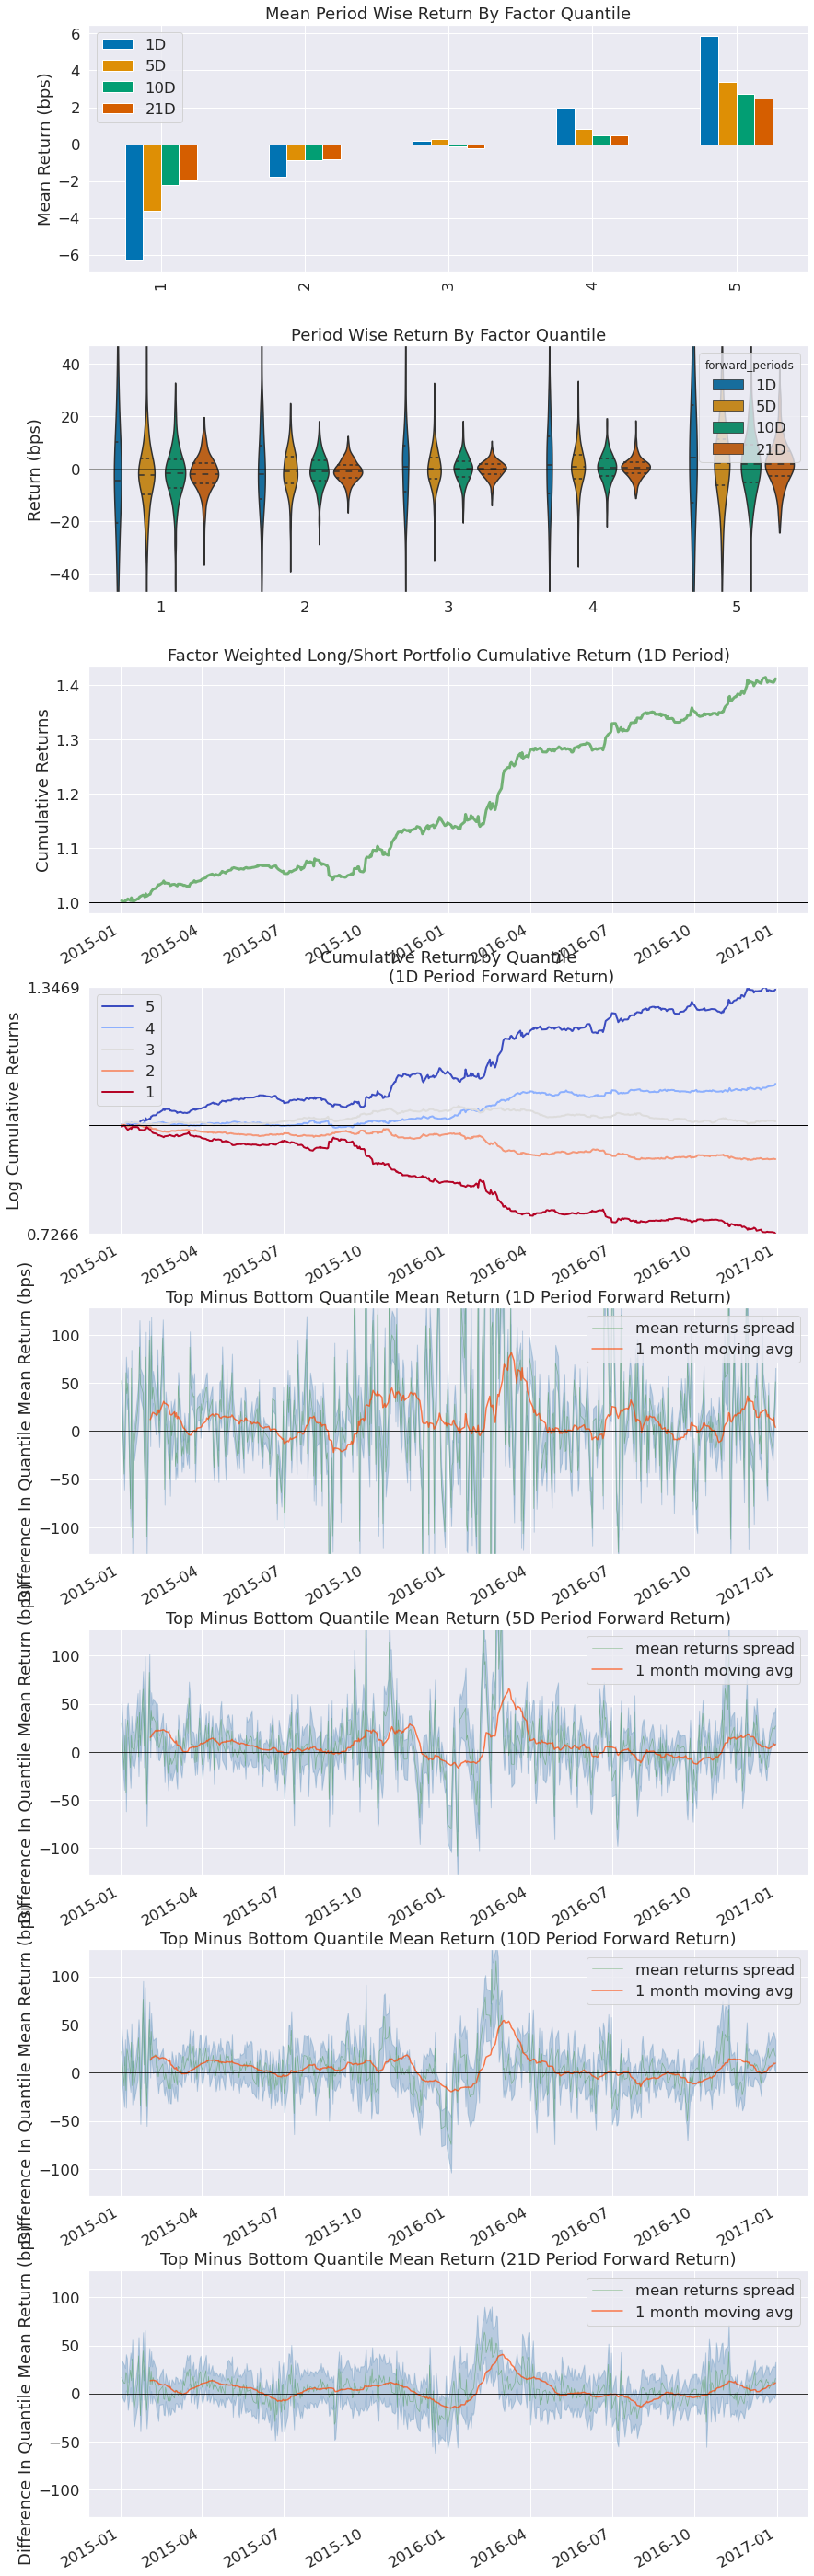

Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.021,0.022,0.034
IC Std.,0.126,0.136,0.141,0.140
Risk-Adjusted IC,0.162,0.158,0.156,0.246
t-stat(IC),3.638,3.545,3.501,5.515
p-value(IC),0.000,0.000,0.001,0.000
IC Skew,0.065,0.249,0.246,0.087
IC Kurtosis,0.970,1.544,0.567,0.740


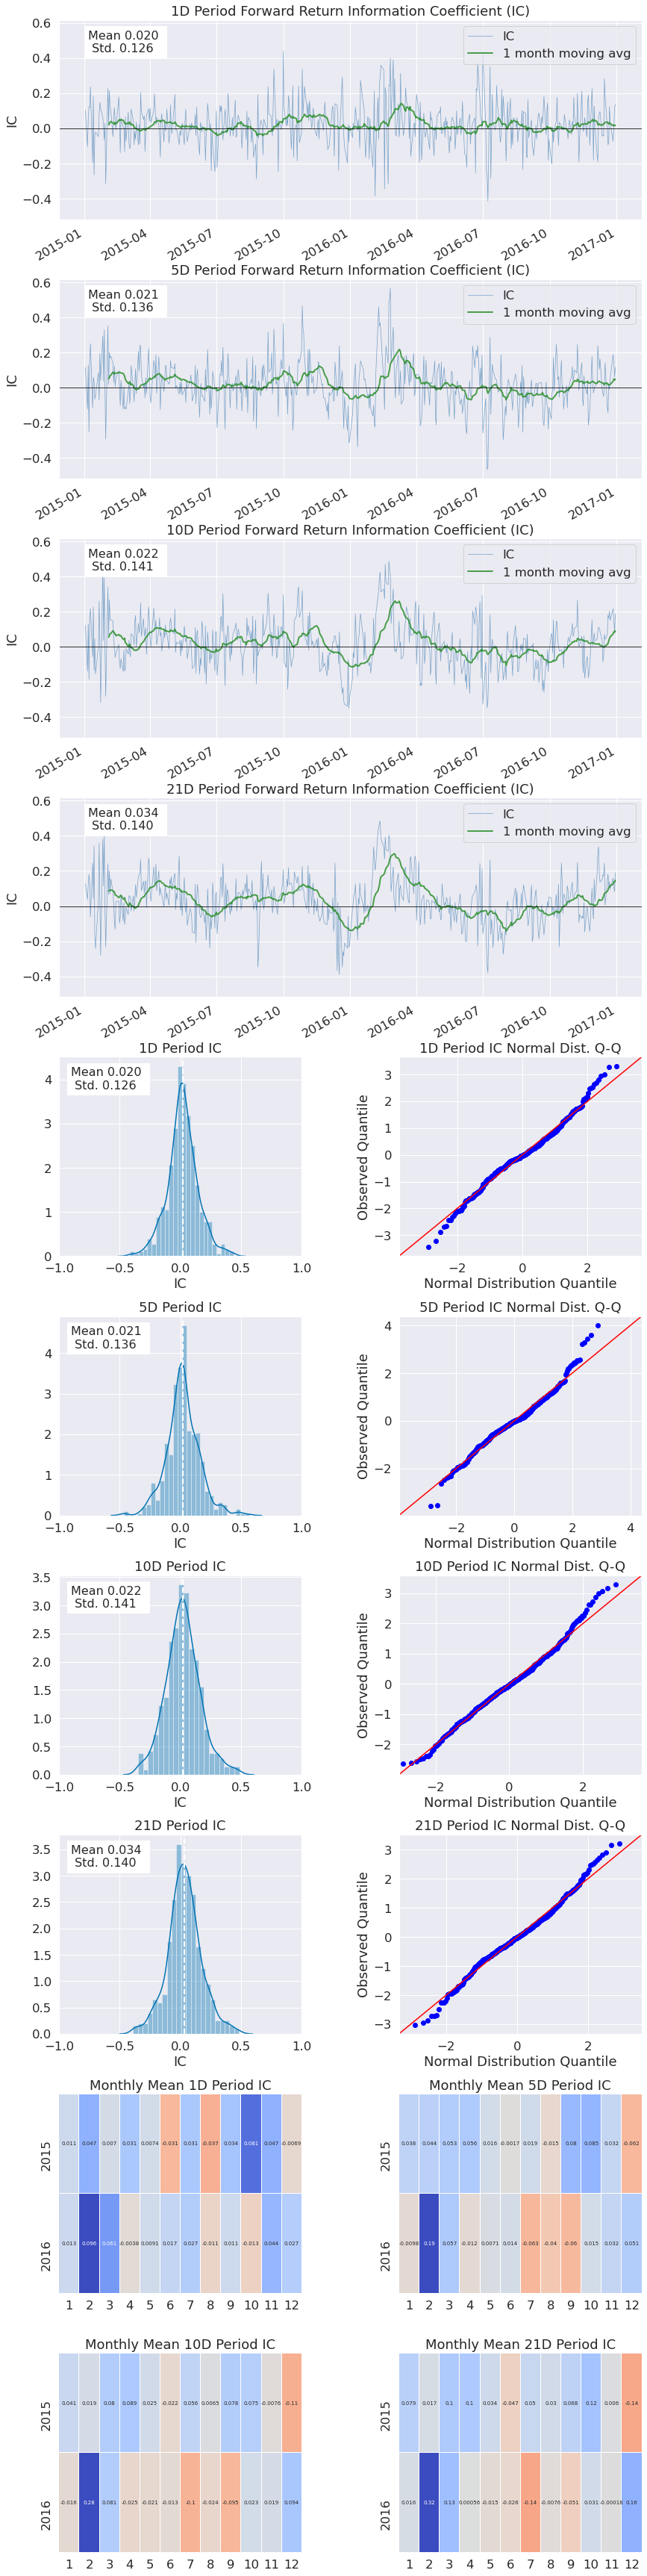

AttributeError: 'Index' object has no attribute 'get_values'

In [73]:
create_full_tear_sheet(factor_data)

### CatBoost

#### Select Parameters

In [ ]:
catboost_daily_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/daily_ic')
catboost_daily_ic.info()

In [ ]:
def get_cb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + catboost_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [ ]:
def get_cb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/'
    return key + f'{int(p.max_depth)}/{int(p.min_child_samples)}'

In [ ]:
best_params = get_cb_params(catboost_daily_ic, t=1, best=0)
best_params

In [ ]:
def select_cb_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.max_depth == params.max_depth) &
                       (ic_data.min_child_samples == params.min_child_samples)].set_index('date')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    params = get_cb_params(catboost_daily_ic, t=t)
    data = select_cb_ic(params, catboost_ic, lookahead=t).sort_index()
    rolling = data.rolling(63).ic.mean().dropna()
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.savefig('figures/rolling_ic_cb', dpi=300);

#### Get Predictions

In [ ]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_cb_params(catboost_daily_ic, t=lookahead, best=best)
    key = get_cb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf('data/tuning_catboost.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf('data/tuning_catboost.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [ ]:
best_predictions.to_hdf('data/predictions.h5', f'catboost/train/{lookahead:02}')
best_predictions.info()

#### Get Trade Prices

Using next available prices.

In [ ]:
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = '../data/assets.h5'
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2015': '2017'], 'adj_open']
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [ ]:
test_tickers = best_predictions.index.get_level_values('symbol').unique()

In [ ]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

In [ ]:
# only generate once to save time
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [ ]:
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [ ]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

#### Create AlphaLens Inputs

In [ ]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))

#### Summary Tearsheet

In [ ]:
create_summary_tear_sheet(factor_data)

In [ ]:
create_full_tear_sheet(factor_data)